In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from dp_model.model_files.sfcn import SFCN
from dp_model import dp_loss as dpl
from dp_model import dp_utils as dpu

In [3]:
def give_rand_dist(n_bins,sort=True):
    shift=torch.randint(low=0,high=n_bins,size=[1])
    rand_vec=torch.rand(n_bins)
    if sort:
        rand_vec=torch.sort(rand_vec)[0]
    rand_dist=torch.roll(rand_vec,shifts=[shift])
    rand_dist=rand_dist/rand_dist.sum()
    return(rand_dist)

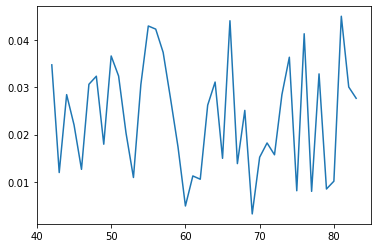

In [4]:
left_limit=42
right_limit=84
bins=np.arange(left_limit,right_limit)
n_bins=right_limit-left_limit
rand_dist=give_rand_dist(n_bins,sort=False)
plt.plot(bins,rand_dist) 

In [5]:
BIN_STEP=1
BIN_RANGE=[left_limit,right_limit]
SIGMA=1
#Set the label translater:
label_translater=dpu.give_label_translater({ 'type': 'label_to_bindist', 
                            'bin_step': BIN_STEP,
                            'bin_range': BIN_RANGE,
                            'sigma': SIGMA})

kl_loss=dpl.my_KLDivLoss
mae_loss=dpl.give_bin_eval(bin_centers=None)

Text(0.5, 1.0, 'With normalization + Enlarged borders')

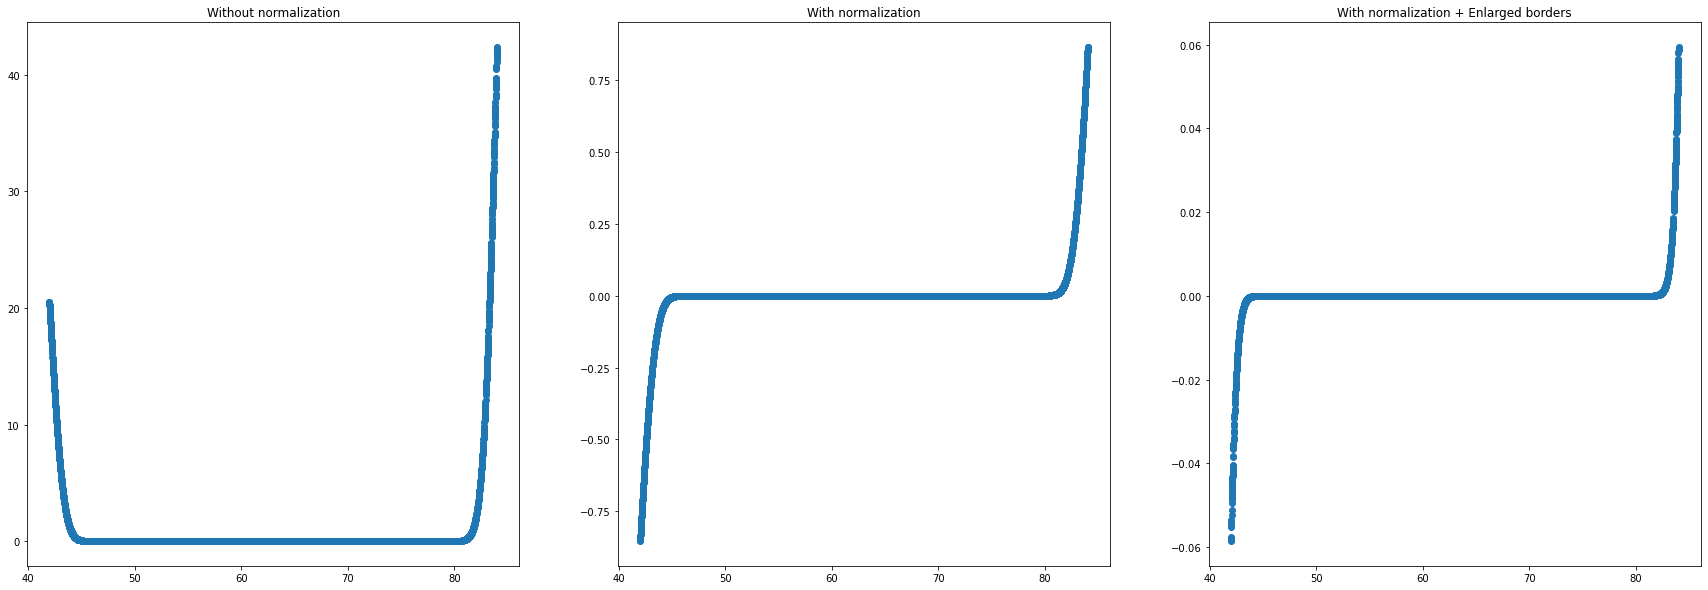

In [35]:
error_list=[]
label_list=[]
n_samples=10000
fig,ax=plt.subplots(ncols=3,figsize=(30,10))
#We control whether the label translater is really injective:
for it in range(n_samples):
    label=(right_limit - left_limit) * torch.rand(1) + left_limit
    base_dist,bin_centers=label_translater(label,sigma=SIGMA,normalize=False)
    #base_dist=base_dist/base_dist.sum()
    pred=dpl.pred_from_dist(torch.log(base_dist.unsqueeze(0)),bin_centers)
    error_list.append((label-pred).item())
    label_list.append(label.item())

ax[0].scatter(label_list,error_list)
ax[0].set_title("Without normalization")
error_list=[]
label_list=[]
for it in range(n_samples):
    label=(right_limit - left_limit) * torch.rand(1) + left_limit
    base_dist,bin_centers=label_translater(label,sigma=SIGMA)
    base_dist=base_dist/base_dist.sum()
    pred=dpl.pred_from_dist(torch.log(base_dist.unsqueeze(0)),bin_centers)
    error_list.append((label-pred).item())
    label_list.append(label.item())
    #print(base_dist.sum())

ax[1].scatter(label_list,error_list)
ax[1].set_title("With normalization")

error_list=[]
label_list=[]
label_translater_enl=dpu.give_label_translater({ 'type': 'label_to_bindist', 
                            'bin_step': 1,
                            'bin_range': [40,86],
                            'sigma': SIGMA})

for it in range(n_samples):
    label=(right_limit - left_limit) * torch.rand(1) + left_limit
    base_dist,bin_centers=label_translater_enl(label,sigma=SIGMA) 
    pred=dpl.pred_from_dist(torch.log(base_dist.unsqueeze(0)),bin_centers)
    error_list.append((label-pred).item())
    label_list.append(label.item())
    #print(base_dist.sum())

ax[2].scatter(label_list,error_list)
ax[2].set_title("With normalization + Enlarged borders")

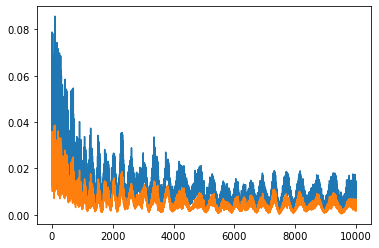

In [6]:
n_in=4
n_hidden=100
batch_size=10
loss_func=nn.KLDivLoss()
loss_func_1=nn.MSELoss()
n_epochs=10000
model=nn.Sequential(nn.Linear(n_in,n_hidden),nn.ReLU(),nn.Linear(n_hidden,n_in))
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)
loss_list=[]
mse_list=[]
for it in range(n_epochs):
    y=torch.rand(batch_size,n_in)
    y=y/y.sum(dim=1)[:,None]
    x=torch.sqrt(y)-2
    out=F.log_softmax(model(x))
    loss=loss_func(out,y)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    mse_list.append(loss_func_1(torch.exp(out),y))



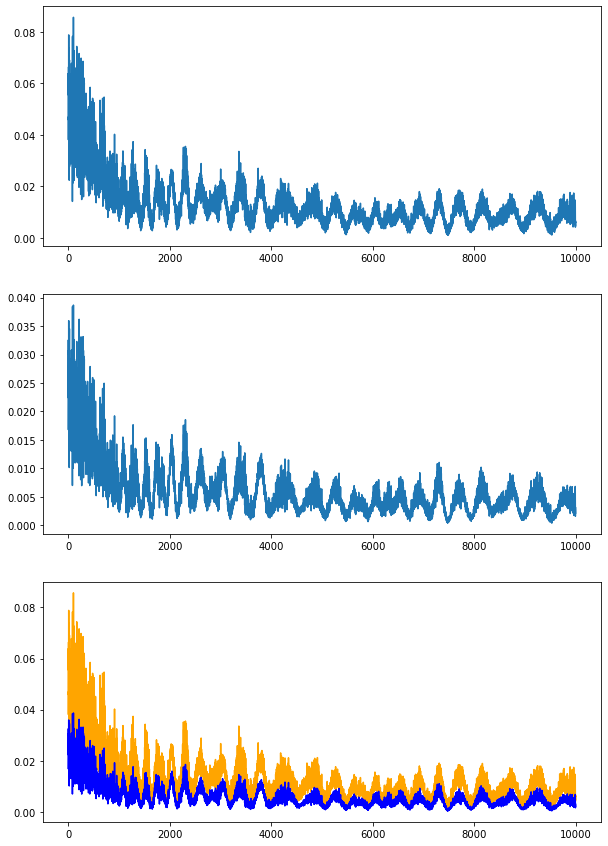

In [16]:
#In the plot below, one can see that the mean squared error and KL-divergence
#are quite correlated.    
fig, ax=plt.subplots(nrows=3,ncols=1,figsize=(10,15))

ax[0].plot(loss_list)
ax[1].plot(mse_list)
ax[2].plot(loss_list,color='orange')
ax[2].plot(mse_list,color='blue')

1.7253605

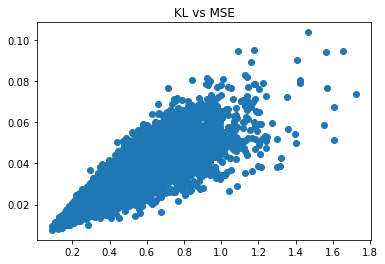

In [38]:
n_samples=10000
dim=20
x=torch.rand(n_samples,dim)
x=x/x.sum(dim=1)[:,None]
y=torch.rand(n_samples,dim)
y=y/y.sum(dim=1)[:,None]
kl_loss=nn.KLDivLoss(reduction='none')
mse_loss=nn.MSELoss(reduction='none')

kls=kl_loss(torch.log(x),y).sum(dim=1)
mses=mse_loss(x,y).sum(dim=1)
plt.scatter(kls,mses)
plt.title("KL vs MSE")
np.corrcoef(kls,mses)
np.max(np.array(kls))



In [39]:
y=torch.rand(batch_size,n_in)
y=y/y.sum(dim=1)[:,None]
x=torch.sqrt(y)-2
out=F.softmax(model(x))
print(out-y)


tensor([[-0.0463, -0.0005,  0.0110,  0.0358],
        [-0.0133, -0.0556,  0.0396,  0.0294],
        [-0.0103, -0.0272,  0.0464, -0.0090],
        [-0.1291,  0.0056,  0.0498,  0.0737],
        [-0.0389, -0.0346,  0.0253,  0.0482],
        [ 0.0265, -0.0310,  0.0025,  0.0021],
        [-0.0779,  0.0566, -0.0281,  0.0494],
        [-0.1092,  0.0078,  0.0230,  0.0784],
        [-0.1264,  0.0140,  0.0425,  0.0699],
        [-0.0686,  0.0230,  0.0041,  0.0415]], grad_fn=<SubBackward0>)


In [ ]:
n_samples=1000
kl_list=[]
mae_list=[]
for i in range(n_samples):
    rand_dist=give_rand_dist(n_bins,sort=False)
    log_rand_dist=torch.log(rand_dist)
    label=(right_limit - left_limit) * torch.rand(1) + left_limit
    base_dist,bin_centers=label_translater(label)
    base_dist=base_dist/base_dist.sum()
    kl_list.append(kl_loss(log_rand_dist.unsqueeze(0),base_dist.unsqueeze(0)))
    mae_list.append(mae_loss(log_rand_dist.unsqueeze(0),base_dist.unsqueeze(0),bin_centers))
    #print(label)
    #print(dpu.pred_from_dist(log_probs,bin_centers))

In [ ]:
plt.scatter(kl_list,mae_list)